# Yukawa Coupling Analysis

The central claim of the RS framework: mass hierarchies from geometry → Yukawas should be $\mathcal{O}(1)$.

This notebook examines the 6 rescaled Yukawa eigenvalues $\bar{Y}_{E_i}$, $\bar{Y}_{N_i}$ across the scan,
focusing on how MEG II 2025 reshapes the viable Yukawa landscape compared to the paper era.

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.rcParams.update({
    'figure.dpi': 130,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
})

# Load data
files = sorted(glob.glob('scan_outputs/scan_shard_*_of_016.csv'))
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# Derive paper-era pass/fail
C_MEGII = np.sqrt(1.5e-13 / 4e-8)
C_PAPER = 0.02
df['lfv_ratio_paper'] = df['lfv_ratio'] * (C_MEGII / C_PAPER)
df['lfv_passes_paper'] = df['lfv_ratio_paper'] <= 1.0
df['passes_paper_era'] = df['perturbative'] & df['natural'] & df['lfv_passes_paper']

# Subsets
pn = df[df.perturbative & df.natural].copy()      # perturbative + natural (before LFV)
paper = df[df.passes_paper_era].copy()             # paper-era viable
viable = df[df.passes_all].copy()                  # MEG II viable

y_E_cols = ['Y_E_bar_1', 'Y_E_bar_2', 'Y_E_bar_3']
y_N_cols = ['Y_N_bar_1', 'Y_N_bar_2', 'Y_N_bar_3']
y_all_cols = y_E_cols + y_N_cols
y_labels_E = [r'$\bar{Y}_{e}$', r'$\bar{Y}_{\mu}$', r'$\bar{Y}_{\tau}$']
y_labels_N = [r'$\bar{Y}_{\nu_1}$', r'$\bar{Y}_{\nu_2}$', r'$\bar{Y}_{\nu_3}$']
y_labels_all = y_labels_E + y_labels_N

print(f'Total: {len(df):,}  |  Pert+Nat: {len(pn):,}  |  Paper: {len(paper):,}  |  MEG II: {len(viable):,}')

Total: 465,125  |  Pert+Nat: 18,282  |  Paper: 6,098  |  MEG II: 1,222


---
## 1. All 6 Yukawas: violin comparison

Three populations side-by-side: perturbative+natural (before LFV), paper-era viable, MEG II viable.  
Watch how LFV squeezes $\bar{Y}_N$ while leaving $\bar{Y}_E$ untouched.

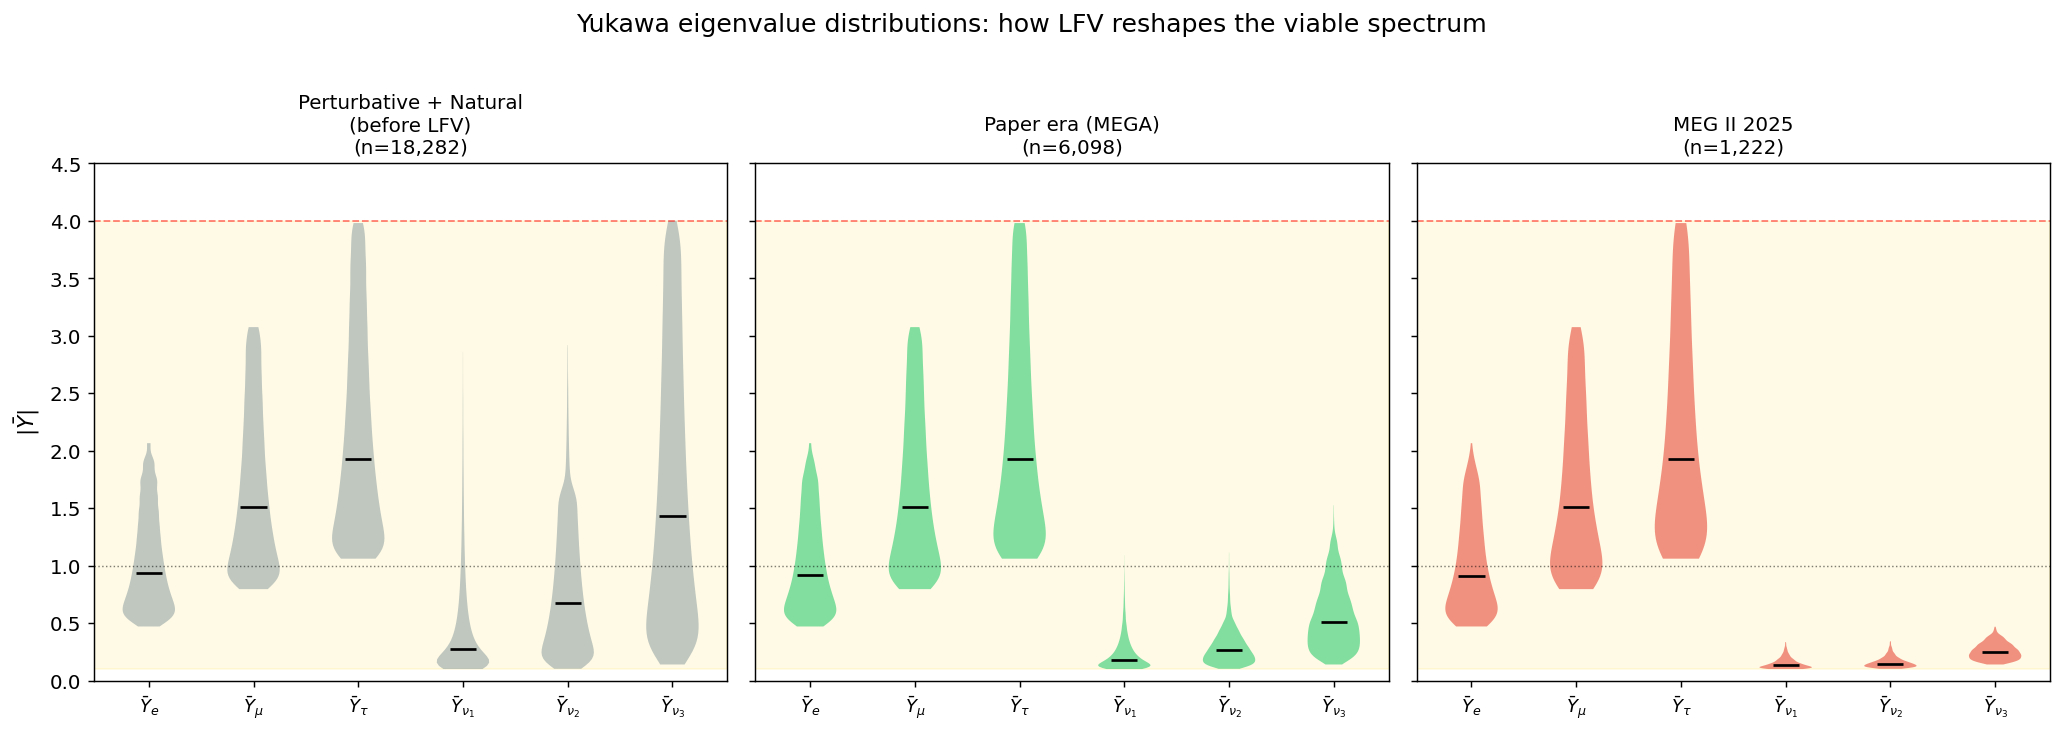

In [2]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5.5), sharey=True)

datasets = [
    (pn, 'Perturbative + Natural\n(before LFV)', '#95a5a6'),
    (paper, 'Paper era (MEGA)', '#2ecc71'),
    (viable, 'MEG II 2025', '#e74c3c'),
]

for ax, (data, title, color) in zip(axes, datasets):
    if len(data) < 2:
        ax.set_title(f'{title}\n(no data)')
        continue
    vals = [data[col].dropna().values for col in y_all_cols]
    parts = ax.violinplot(vals, positions=range(6), showmedians=True, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_alpha(0.6)
    parts['cmedians'].set_color('black')
    
    # Naturalness band
    ax.axhspan(0.1, 4.0, color='gold', alpha=0.1, zorder=0)
    ax.axhline(1.0, color='black', ls=':', lw=0.8, alpha=0.5)
    ax.axhline(4.0, color='red', ls='--', lw=1, alpha=0.5)
    
    ax.set_xticks(range(6))
    ax.set_xticklabels(y_labels_all, fontsize=10)
    ax.set_title(f'{title}\n(n={len(data):,})', fontsize=11)
    ax.set_ylim(0, 4.5)

axes[0].set_ylabel(r'$|\bar{Y}|$')
fig.suptitle('Yukawa eigenvalue distributions: how LFV reshapes the viable spectrum',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 2. The "money plot": Yukawa spectrum for every viable point

Each line connects the 6 eigenvalues of one viable point, ordered $\bar{Y}_{e}, \bar{Y}_{\mu}, \bar{Y}_{\tau}, \bar{Y}_{\nu_1}, \bar{Y}_{\nu_2}, \bar{Y}_{\nu_3}$.  
Color encodes $\Lambda_{\text{IR}}$.

/tmp/ipykernel_2809462/764576953.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


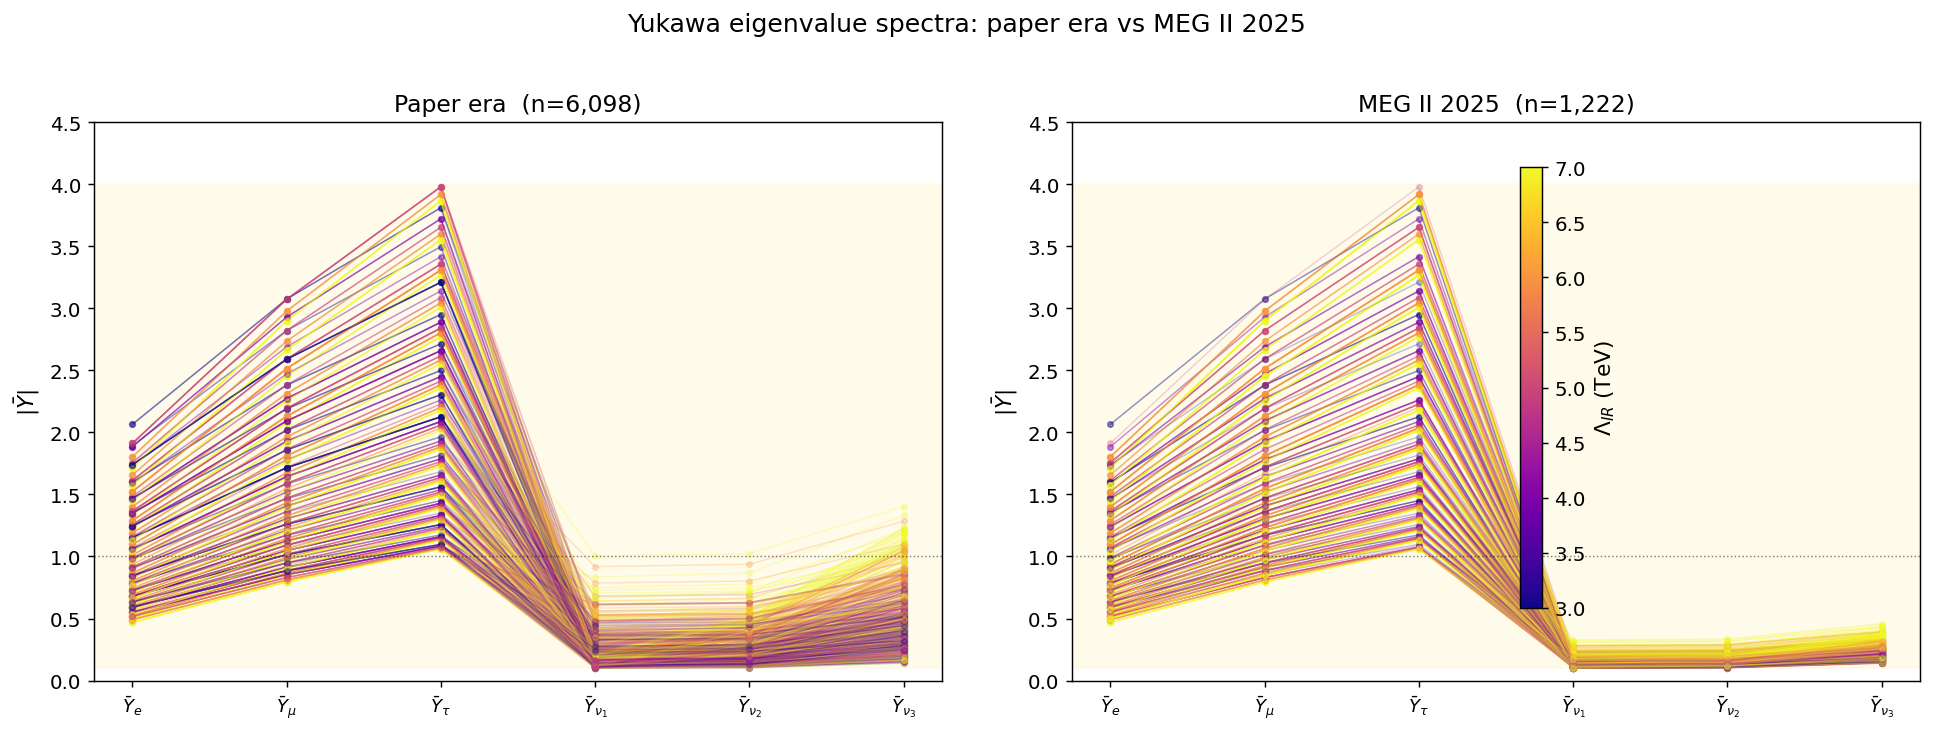

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5.5))
cmap = plt.cm.plasma
lam_min, lam_max = viable.Lambda_IR.min(), viable.Lambda_IR.max()
norm = mcolors.Normalize(vmin=lam_min/1000, vmax=lam_max/1000)

for ax, (data, title) in zip(axes, [(paper, 'Paper era'), (viable, 'MEG II 2025')]):
    # Subsample for readability
    sample = data.sample(min(500, len(data)), random_state=42) if len(data) > 500 else data
    xs = np.arange(6)
    for _, row in sample.iterrows():
        ys = [row[c] for c in y_all_cols]
        c = cmap(norm(row.Lambda_IR / 1000))
        ax.plot(xs, ys, '-o', color=c, alpha=0.25, ms=3, lw=0.8)

    ax.axhspan(0.1, 4.0, color='gold', alpha=0.08, zorder=0)
    ax.axhline(1.0, color='black', ls=':', lw=0.8, alpha=0.5)
    ax.set_xticks(xs)
    ax.set_xticklabels(y_labels_all, fontsize=10)
    ax.set_ylabel(r'$|\bar{Y}|$')
    ax.set_ylim(0, 4.5)
    ax.set_title(f'{title}  (n={len(data):,})')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=axes, label=r'$\Lambda_{IR}$ (TeV)', shrink=0.8)
fig.suptitle('Yukawa eigenvalue spectra: paper era vs MEG II 2025', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 3. Histograms of each Yukawa: paper era vs MEG II

Overlaid histograms for all 6 eigenvalues. The gap between green (paper) and red (MEG II) reveals the LFV squeeze.

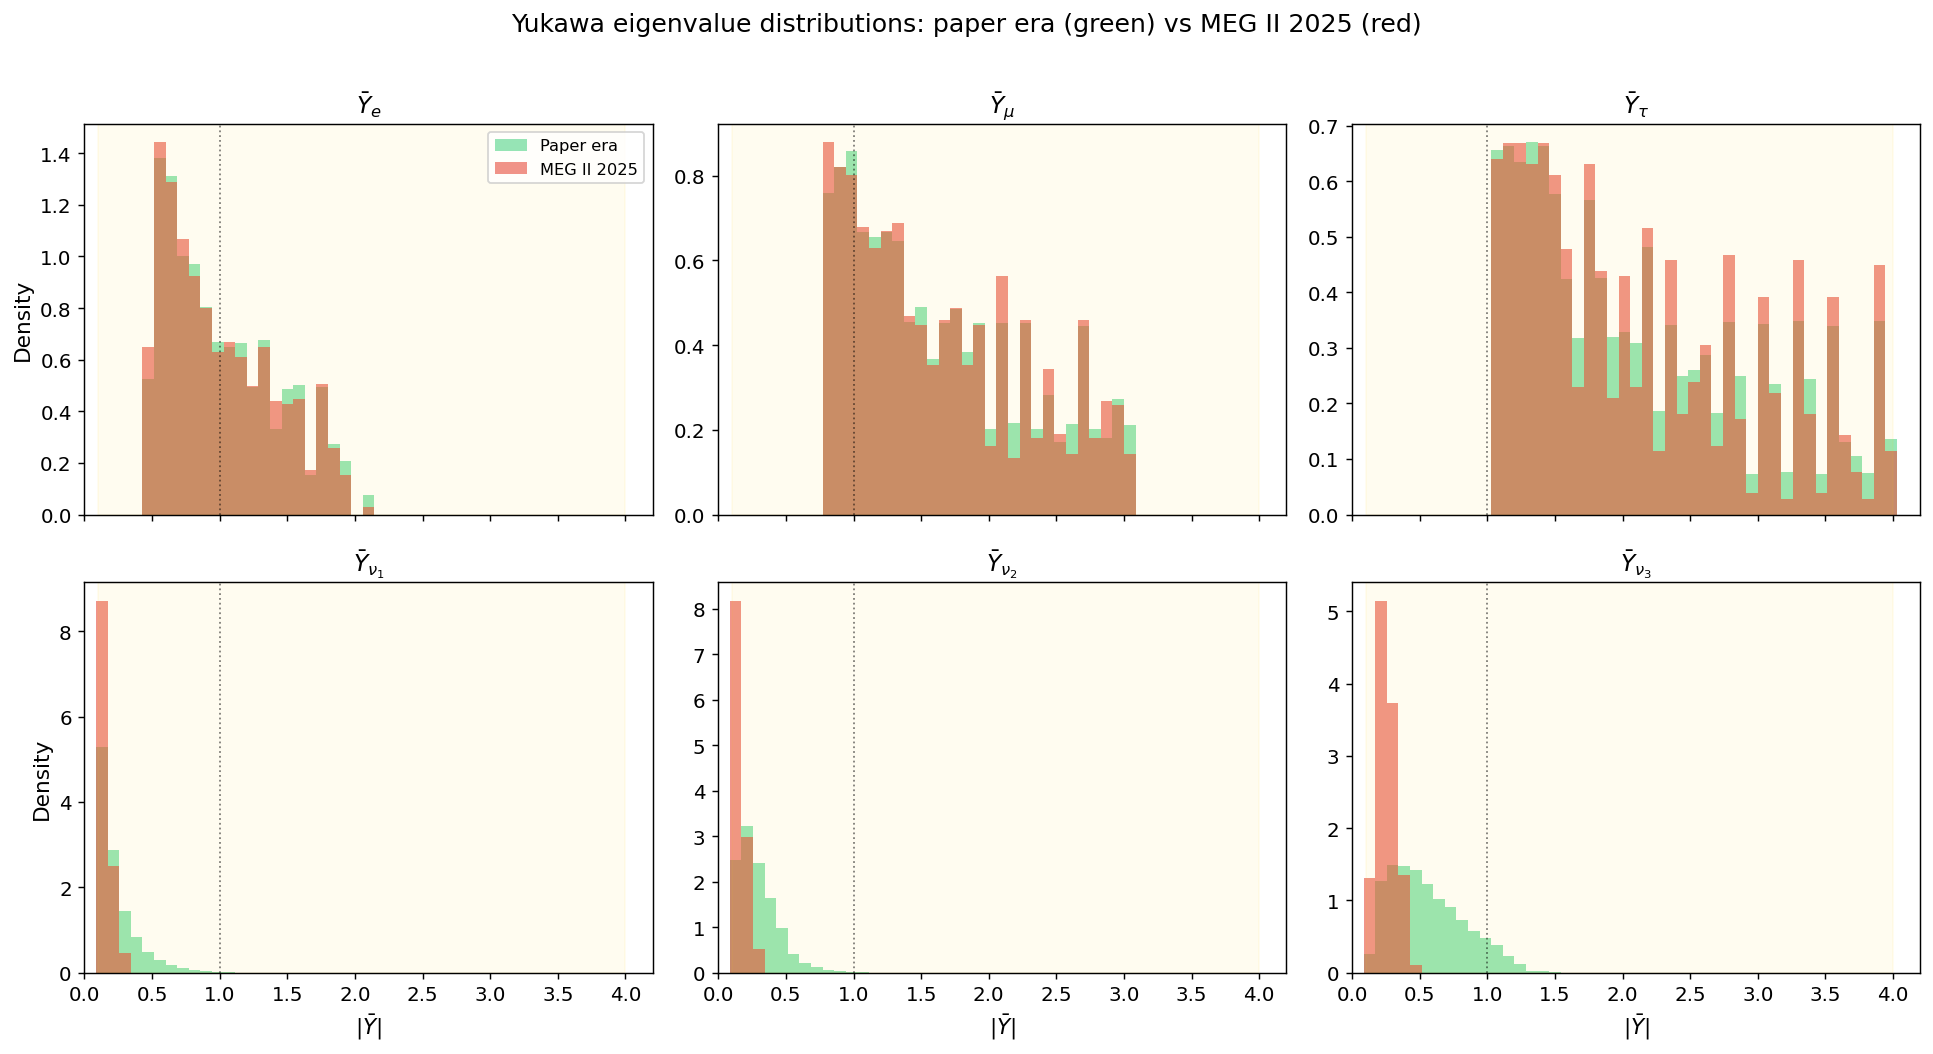

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)

bins = np.linspace(0, 4.2, 50)

for idx, (col, label) in enumerate(zip(y_all_cols, y_labels_all)):
    ax = axes[idx // 3, idx % 3]
    
    ax.hist(paper[col].dropna(), bins=bins, color='#2ecc71', alpha=0.5,
            density=True, label='Paper era')
    ax.hist(viable[col].dropna(), bins=bins, color='#e74c3c', alpha=0.6,
            density=True, label='MEG II 2025')
    
    ax.axvline(1.0, color='black', ls=':', lw=1, alpha=0.5)
    ax.axvspan(0.1, 4.0, color='gold', alpha=0.06)
    ax.set_title(label, fontsize=13)
    ax.set_xlim(0, 4.2)
    if idx >= 3:
        ax.set_xlabel(r'$|\bar{Y}|$')
    if idx % 3 == 0:
        ax.set_ylabel('Density')
    if idx == 0:
        ax.legend(fontsize=9)

fig.suptitle('Yukawa eigenvalue distributions: paper era (green) vs MEG II 2025 (red)',
             fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 4. Each Yukawa vs $M_{KK}$

The key plot: how each $\bar{Y}$ behaves as a function of KK scale.  
Paper-era points in background (green), MEG II on top (red).

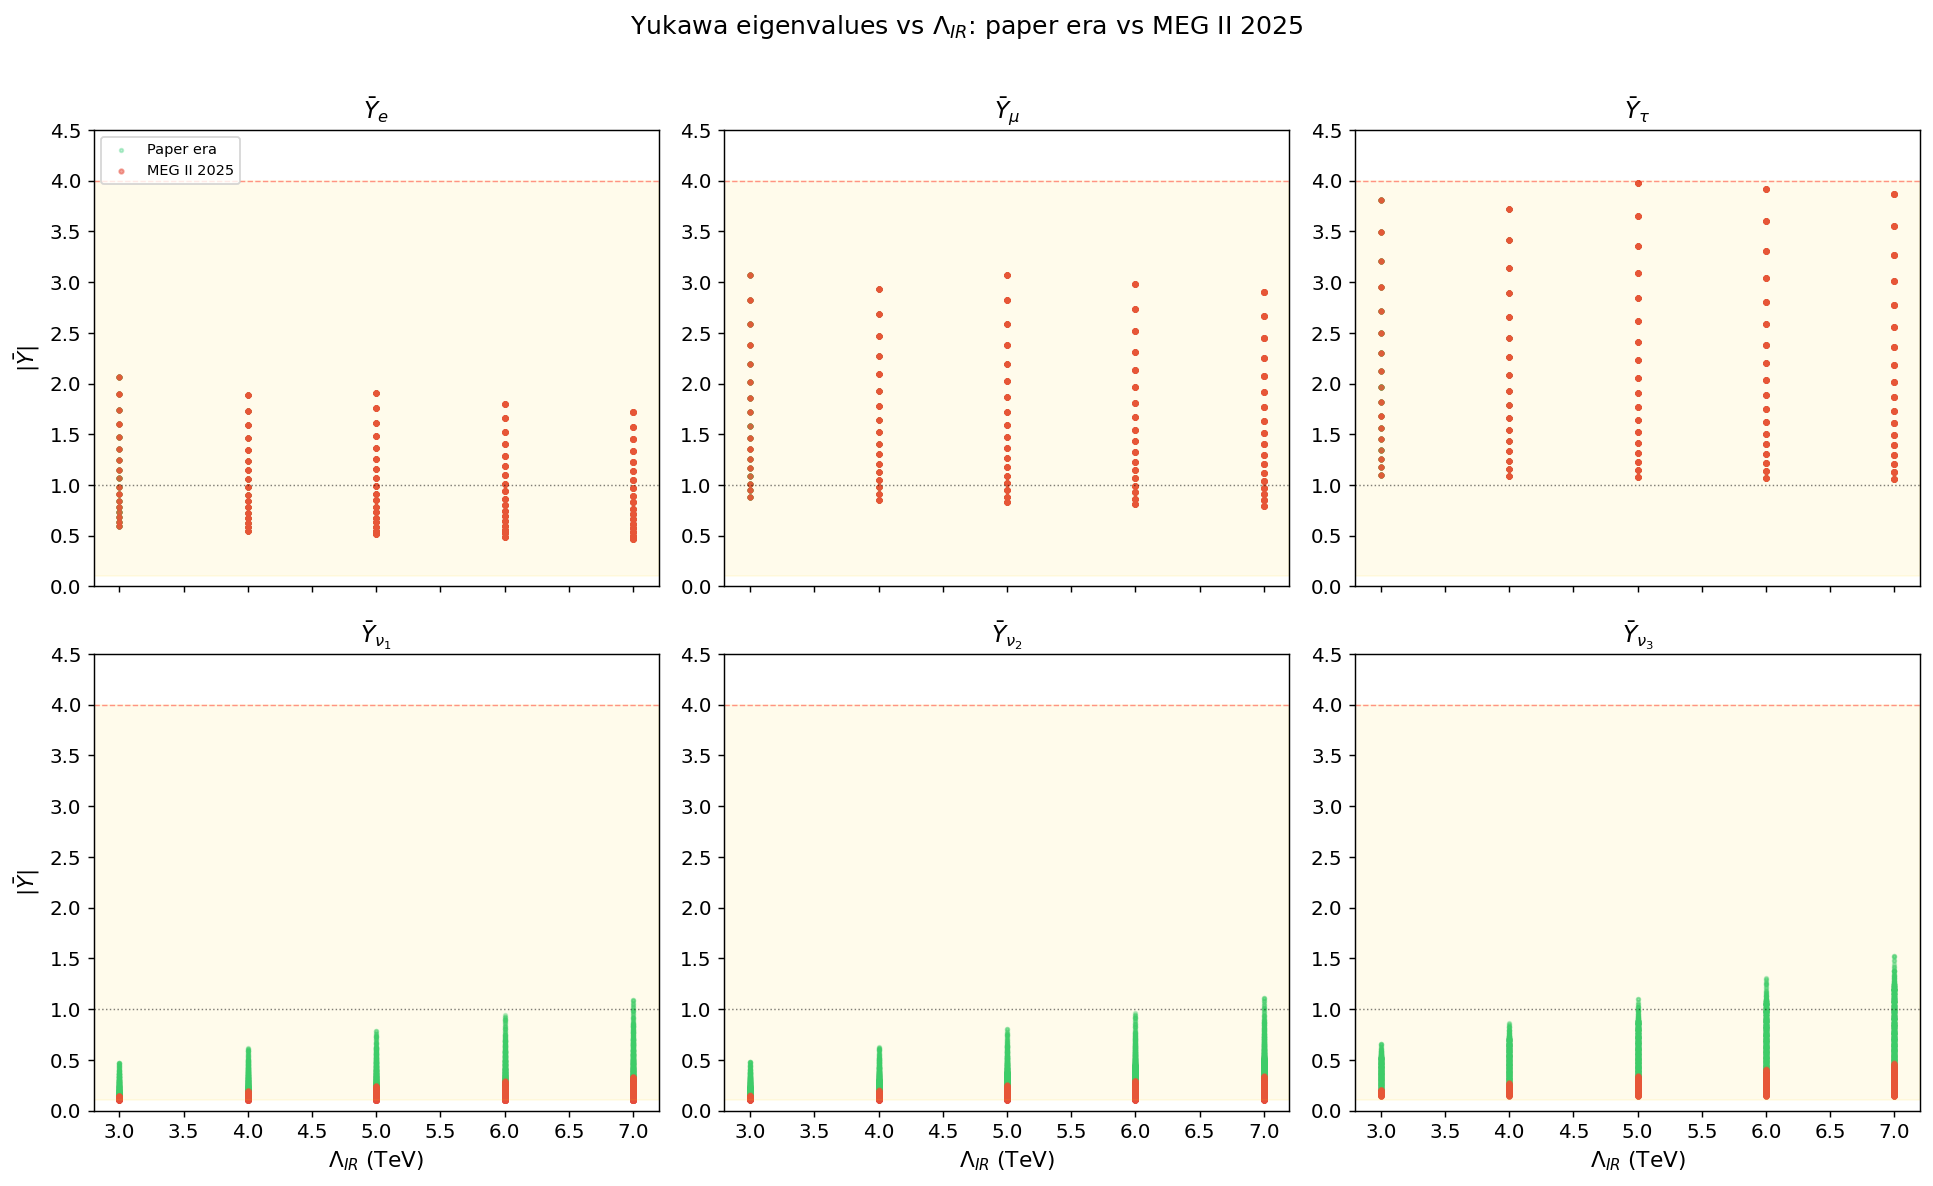

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15, 9), sharex=True)

for idx, (col, label) in enumerate(zip(y_all_cols, y_labels_all)):
    ax = axes[idx // 3, idx % 3]
    
    # Paper era (background)
    ax.scatter(paper.Lambda_IR / 1000, paper[col],
              c='#2ecc71', s=4, alpha=0.3, rasterized=True, label='Paper era')
    # MEG II (foreground)
    ax.scatter(viable.Lambda_IR / 1000, viable[col],
              c='#e74c3c', s=6, alpha=0.5, rasterized=True, label='MEG II 2025')
    
    # Naturalness band
    ax.axhspan(0.1, 4.0, color='gold', alpha=0.08)
    ax.axhline(1.0, color='black', ls=':', lw=0.8, alpha=0.5)
    ax.axhline(4.0, color='red', ls='--', lw=0.8, alpha=0.4)
    
    ax.set_title(label, fontsize=13)
    ax.set_ylim(0, 4.5)
    if idx >= 3:
        ax.set_xlabel(r'$\Lambda_{IR}$ (TeV)')
    if idx % 3 == 0:
        ax.set_ylabel(r'$|\bar{Y}|$')
    if idx == 0:
        ax.legend(fontsize=8, loc='upper left')

fig.suptitle(r'Yukawa eigenvalues vs $\Lambda_{IR}$: paper era vs MEG II 2025',
             fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 5. Projected Yukawas at higher $M_{KK}$

Using all perturbative+natural points, project which would pass LFV at $M_{KK} = 3, 5, 7, 10, 15$ TeV.  
Shows how the neutrino Yukawa window opens up at higher KK scales.

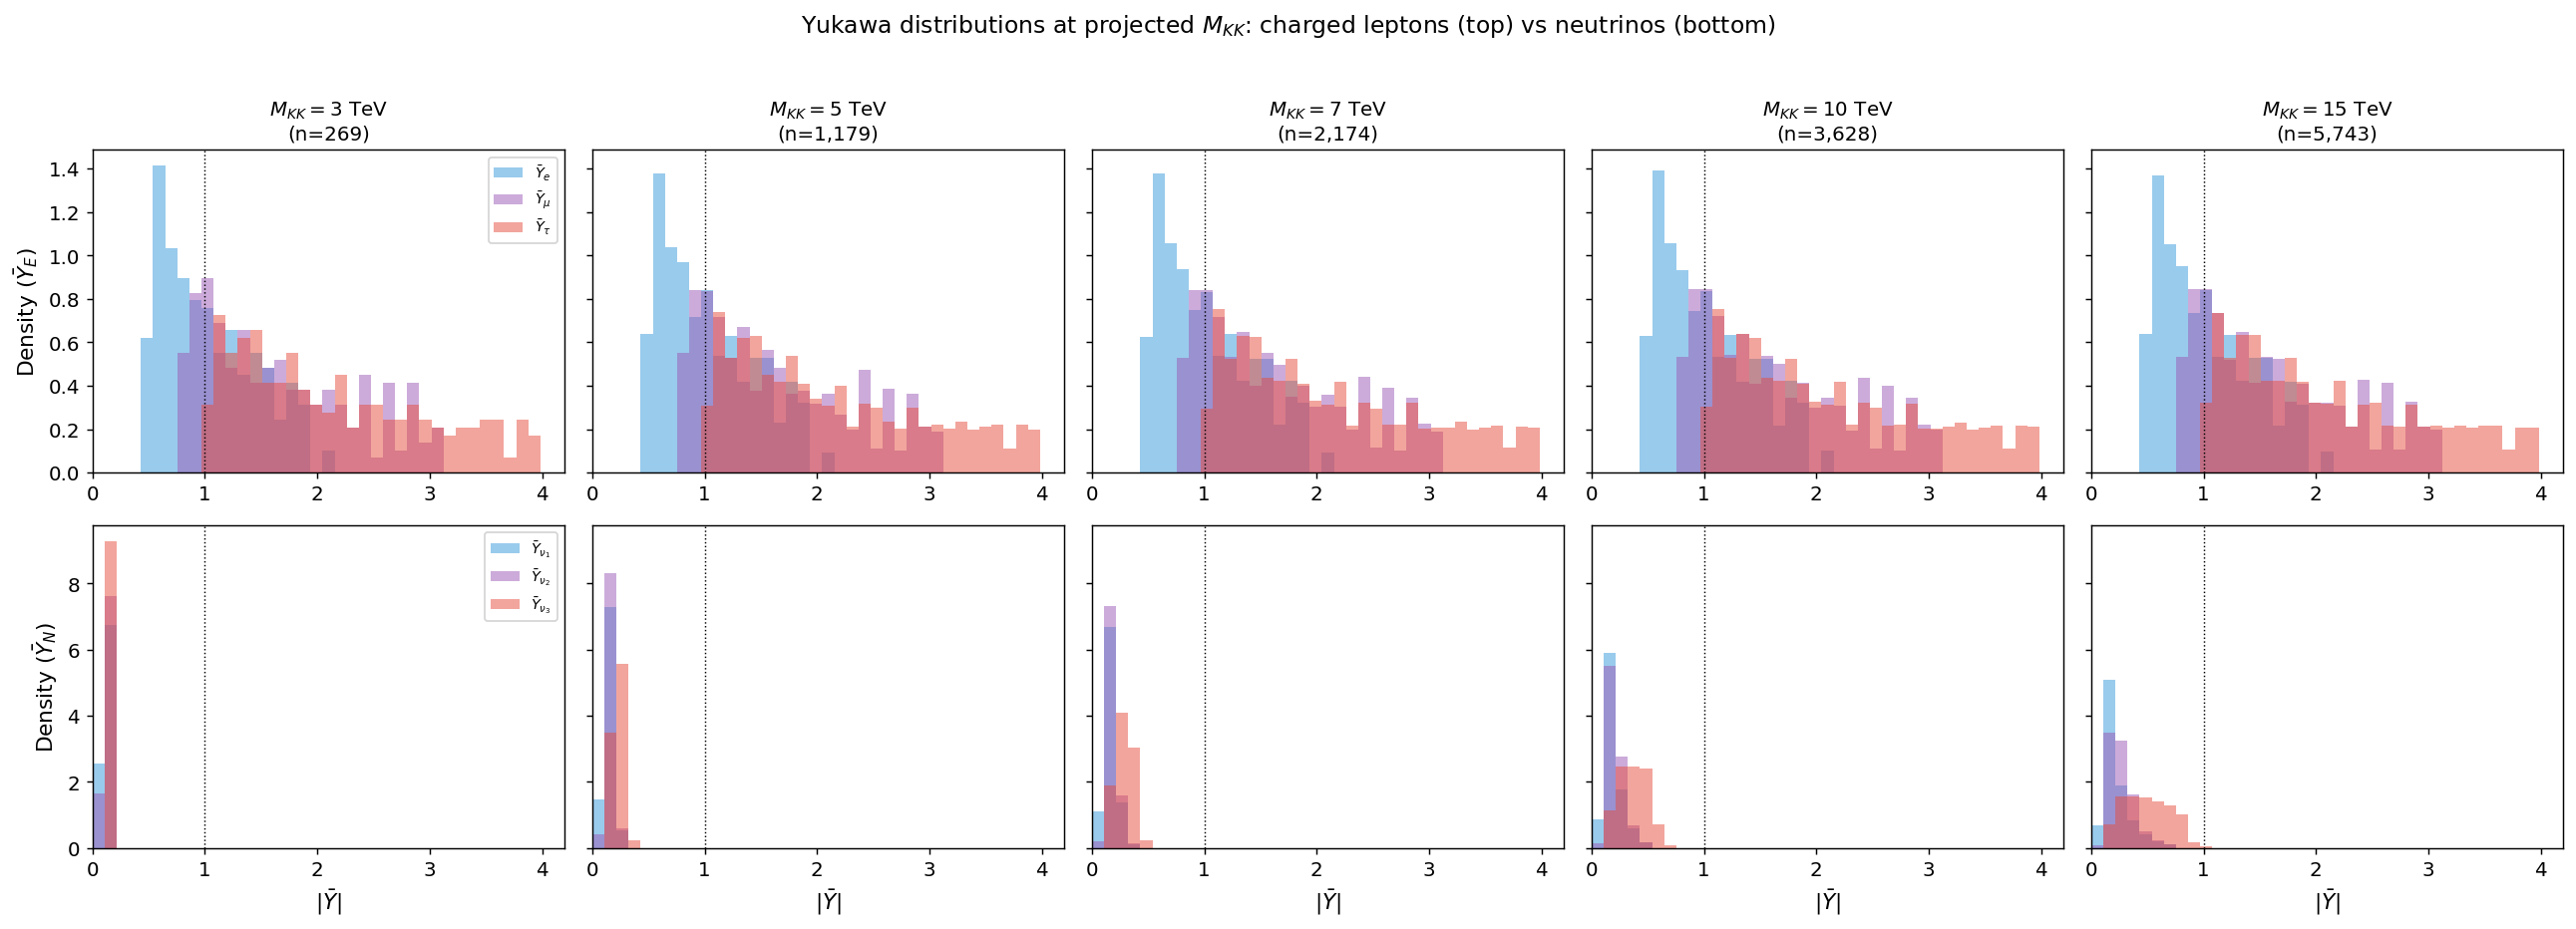

In [6]:
mkk_vals = [3, 5, 7, 10, 15]
fig, axes = plt.subplots(2, len(mkk_vals), figsize=(4*len(mkk_vals), 7),
                          sharey='row')

bins_E = np.linspace(0, 4.2, 40)
bins_N = np.linspace(0, 4.2, 40)

for j, mkk_tev in enumerate(mkk_vals):
    mkk_gev = mkk_tev * 1000
    ratio_at_mkk = pn['lfv_lhs'] / (C_MEGII * (mkk_gev / 3000)**2)
    passes_here = pn[ratio_at_mkk <= 1.0]
    
    # Top row: charged lepton Yukawas
    ax = axes[0, j]
    for col, label, color in zip(y_E_cols, y_labels_E, ['#3498db', '#9b59b6', '#e74c3c']):
        if len(passes_here) > 0:
            ax.hist(passes_here[col].dropna(), bins=bins_E, color=color,
                    alpha=0.5, density=True, label=label)
    ax.axvline(1.0, color='black', ls=':', lw=0.8)
    ax.set_title(f'$M_{{KK}} = {mkk_tev}$ TeV\n(n={len(passes_here):,})', fontsize=11)
    ax.set_xlim(0, 4.2)
    if j == 0:
        ax.set_ylabel(r'Density ($\bar{Y}_E$)')
        ax.legend(fontsize=8)
    
    # Bottom row: neutrino Yukawas
    ax = axes[1, j]
    for col, label, color in zip(y_N_cols, y_labels_N, ['#3498db', '#9b59b6', '#e74c3c']):
        if len(passes_here) > 0:
            ax.hist(passes_here[col].dropna(), bins=bins_N, color=color,
                    alpha=0.5, density=True, label=label)
    ax.axvline(1.0, color='black', ls=':', lw=0.8)
    ax.set_xlabel(r'$|\bar{Y}|$')
    ax.set_xlim(0, 4.2)
    if j == 0:
        ax.set_ylabel(r'Density ($\bar{Y}_N$)')
        ax.legend(fontsize=8)

fig.suptitle(r'Yukawa distributions at projected $M_{KK}$: charged leptons (top) vs neutrinos (bottom)',
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 6. Neutrino Yukawa trio: $\bar{Y}_{\nu_1}$ vs $\bar{Y}_{\nu_3}$

The internal hierarchy of neutrino Yukawas, colored by LFV ratio.  
Points near the bound (ratio → 1) cluster at the upper edge.

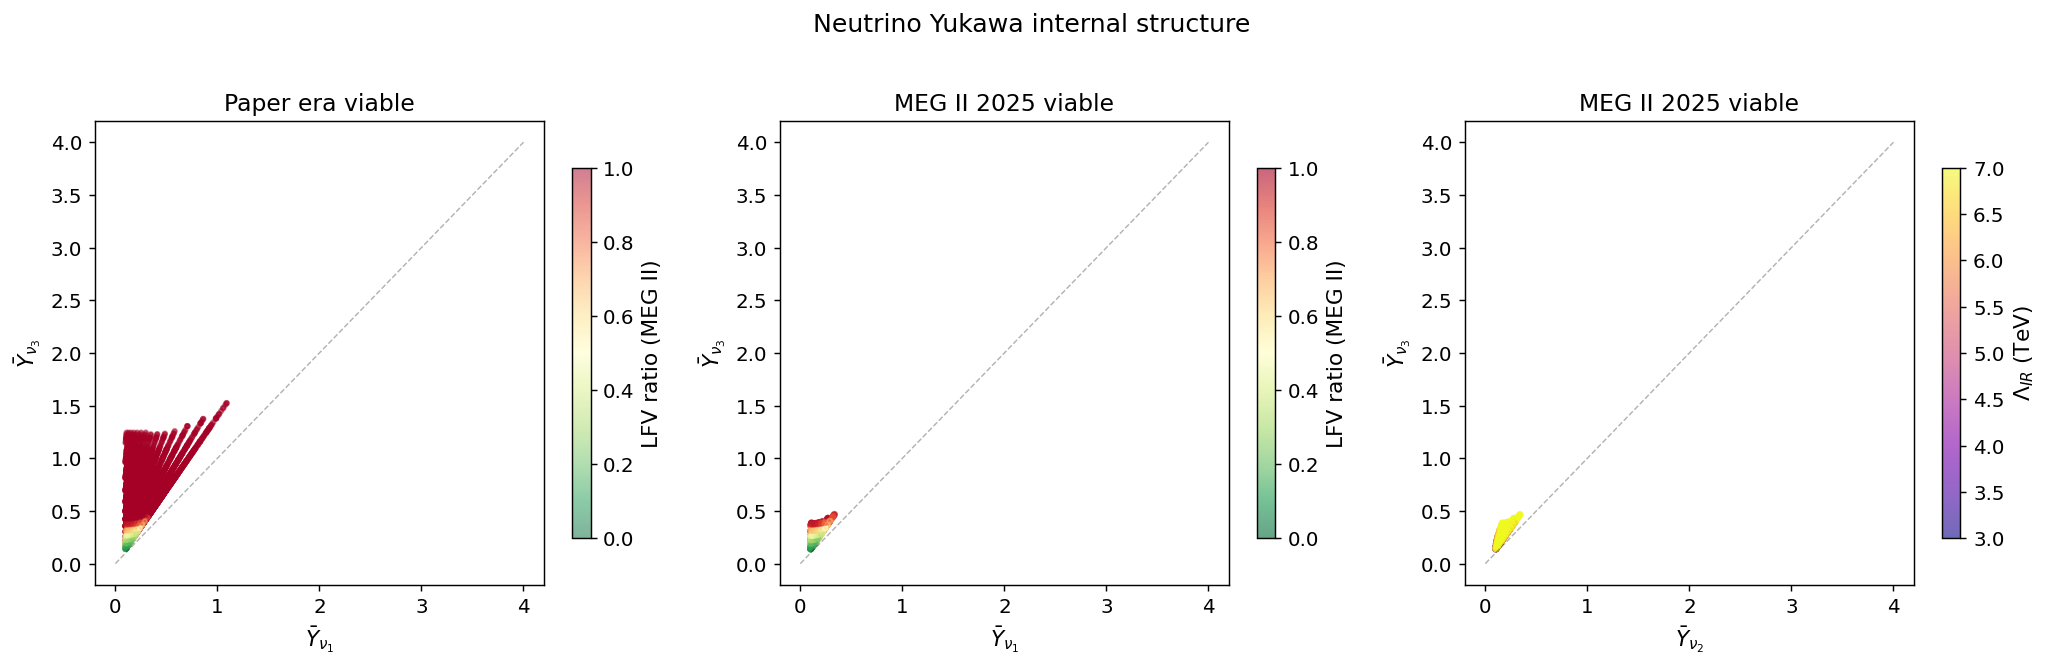

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Left: Y_N_1 vs Y_N_3 for paper era
ax = axes[0]
sc = ax.scatter(paper.Y_N_bar_1, paper.Y_N_bar_3,
                c=paper.lfv_ratio, cmap='RdYlGn_r', vmin=0, vmax=1,
                s=6, alpha=0.5, rasterized=True)
fig.colorbar(sc, ax=ax, label='LFV ratio (MEG II)', shrink=0.8)
ax.set_xlabel(r'$\bar{Y}_{\nu_1}$')
ax.set_ylabel(r'$\bar{Y}_{\nu_3}$')
ax.set_title('Paper era viable')
ax.plot([0, 4], [0, 4], 'k--', lw=0.8, alpha=0.3)

# Middle: Y_N_1 vs Y_N_3 for MEG II
ax = axes[1]
sc = ax.scatter(viable.Y_N_bar_1, viable.Y_N_bar_3,
                c=viable.lfv_ratio, cmap='RdYlGn_r', vmin=0, vmax=1,
                s=8, alpha=0.6, rasterized=True)
fig.colorbar(sc, ax=ax, label='LFV ratio (MEG II)', shrink=0.8)
ax.set_xlabel(r'$\bar{Y}_{\nu_1}$')
ax.set_ylabel(r'$\bar{Y}_{\nu_3}$')
ax.set_title('MEG II 2025 viable')
ax.plot([0, 4], [0, 4], 'k--', lw=0.8, alpha=0.3)

# Right: Y_N_2 vs Y_N_3 for MEG II, colored by Lambda_IR
ax = axes[2]
sc = ax.scatter(viable.Y_N_bar_2, viable.Y_N_bar_3,
                c=viable.Lambda_IR / 1000, cmap='plasma',
                s=8, alpha=0.6, rasterized=True)
fig.colorbar(sc, ax=ax, label=r'$\Lambda_{IR}$ (TeV)', shrink=0.8)
ax.set_xlabel(r'$\bar{Y}_{\nu_2}$')
ax.set_ylabel(r'$\bar{Y}_{\nu_3}$')
ax.set_title('MEG II 2025 viable')
ax.plot([0, 4], [0, 4], 'k--', lw=0.8, alpha=0.3)

fig.suptitle('Neutrino Yukawa internal structure', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 7. Charged lepton Yukawas vs $c_L$

The $\bar{Y}_E$ are set by geometry: $\bar{Y}_{E_i} = m_{E_i}/(v\, f_L\, f_{E_i})$.  
Since $f_L = f_{\text{IR}}(c_L, \varepsilon)$, larger $c_L$ → smaller $f_L$ → larger $\bar{Y}_E$.

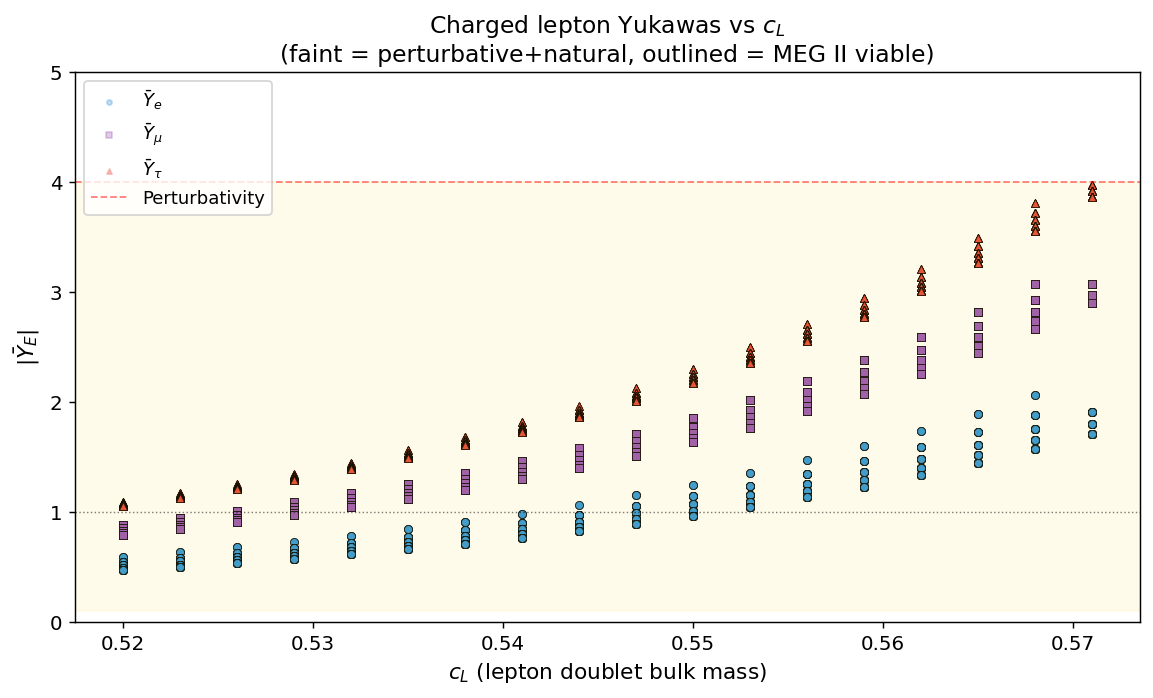

In [8]:
fig, ax = plt.subplots(figsize=(9, 5.5))

colors_E = ['#3498db', '#9b59b6', '#e74c3c']
markers_E = ['o', 's', '^']

# Use perturbative+natural points (more spread)
sample = pn.sample(min(3000, len(pn)), random_state=42)
for col, label, color, marker in zip(y_E_cols, y_labels_E, colors_E, markers_E):
    ax.scatter(sample.c_L, sample[col], c=color, s=8, alpha=0.3,
              marker=marker, label=label, rasterized=True)

# Overlay viable points with edges
for col, color, marker in zip(y_E_cols, colors_E, markers_E):
    ax.scatter(viable.c_L, viable[col], facecolors=color, edgecolors='black',
              s=20, alpha=0.7, marker=marker, linewidths=0.5, rasterized=True)

ax.axhspan(0.1, 4.0, color='gold', alpha=0.08)
ax.axhline(4.0, color='red', ls='--', lw=1, alpha=0.5, label='Perturbativity')
ax.axhline(1.0, color='black', ls=':', lw=0.8, alpha=0.5)

ax.set_xlabel('$c_L$ (lepton doublet bulk mass)')
ax.set_ylabel(r'$|\bar{Y}_E|$')
ax.set_title(r'Charged lepton Yukawas vs $c_L$'
             '\n(faint = perturbative+natural, outlined = MEG II viable)')
ax.legend(loc='upper left', fontsize=10)
ax.set_ylim(0, 5)
plt.tight_layout()
plt.show()

## 8. Neutrino Yukawas vs $c_N$ and $m_{\text{lightest}}$

$\bar{Y}_{N_i} \propto \sqrt{m_{\nu_i}}$, so the lightest neutrino mass directly controls the Yukawa floor.  
$c_N$ controls $f_N$ and $f_N^{\text{UV}}$ which set the seesaw prefactor.

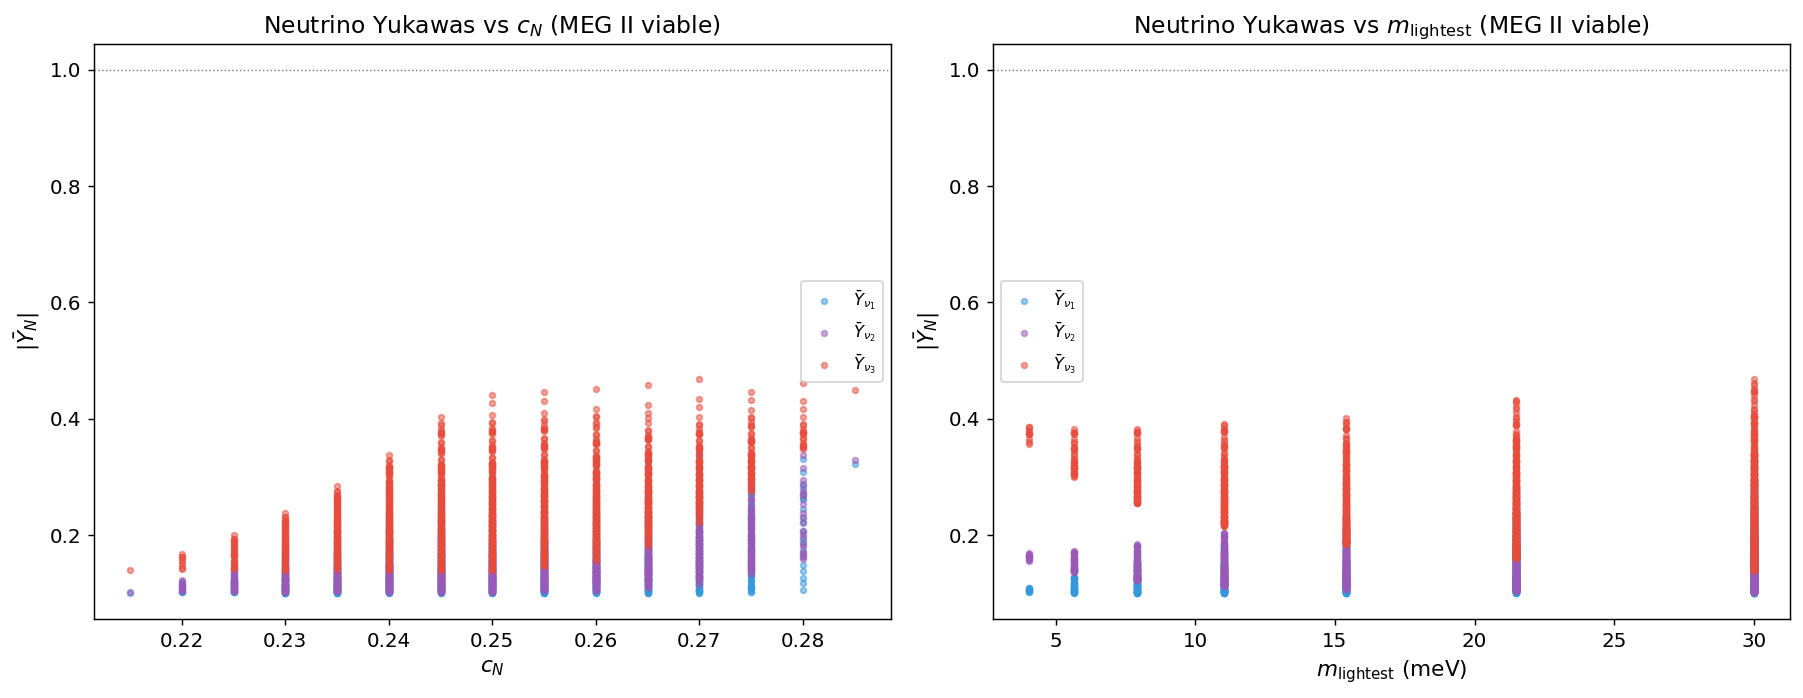

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# Left: Y_N vs c_N
ax = axes[0]
colors_N = ['#3498db', '#9b59b6', '#e74c3c']
for col, label, color in zip(y_N_cols, y_labels_N, colors_N):
    ax.scatter(viable.c_N, viable[col], c=color, s=10, alpha=0.5,
              label=label, rasterized=True)
ax.axhline(1.0, color='black', ls=':', lw=0.8, alpha=0.5)
ax.set_xlabel('$c_N$')
ax.set_ylabel(r'$|\bar{Y}_N|$')
ax.set_title(r'Neutrino Yukawas vs $c_N$ (MEG II viable)')
ax.legend(fontsize=9)

# Right: Y_N vs m_lightest
ax = axes[1]
for col, label, color in zip(y_N_cols, y_labels_N, colors_N):
    ax.scatter(viable.lightest_nu_mass * 1e3, viable[col], c=color, s=10,
              alpha=0.5, label=label, rasterized=True)
ax.axhline(1.0, color='black', ls=':', lw=0.8, alpha=0.5)
ax.set_xlabel(r'$m_{\text{lightest}}$ (meV)')
ax.set_ylabel(r'$|\bar{Y}_N|$')
ax.set_title(r'Neutrino Yukawas vs $m_{\text{lightest}}$ (MEG II viable)')
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

## 9. The LFV observable: $|(\bar{Y}_N\bar{Y}_N^\dagger)_{12}|$ vs $M_{KK}$

This is the actual quantity constrained by $\mu\to e\gamma$.
The bound is $C \times (M_{KK}/3\,\text{TeV})^2$, shown as curves for paper era and MEG II.

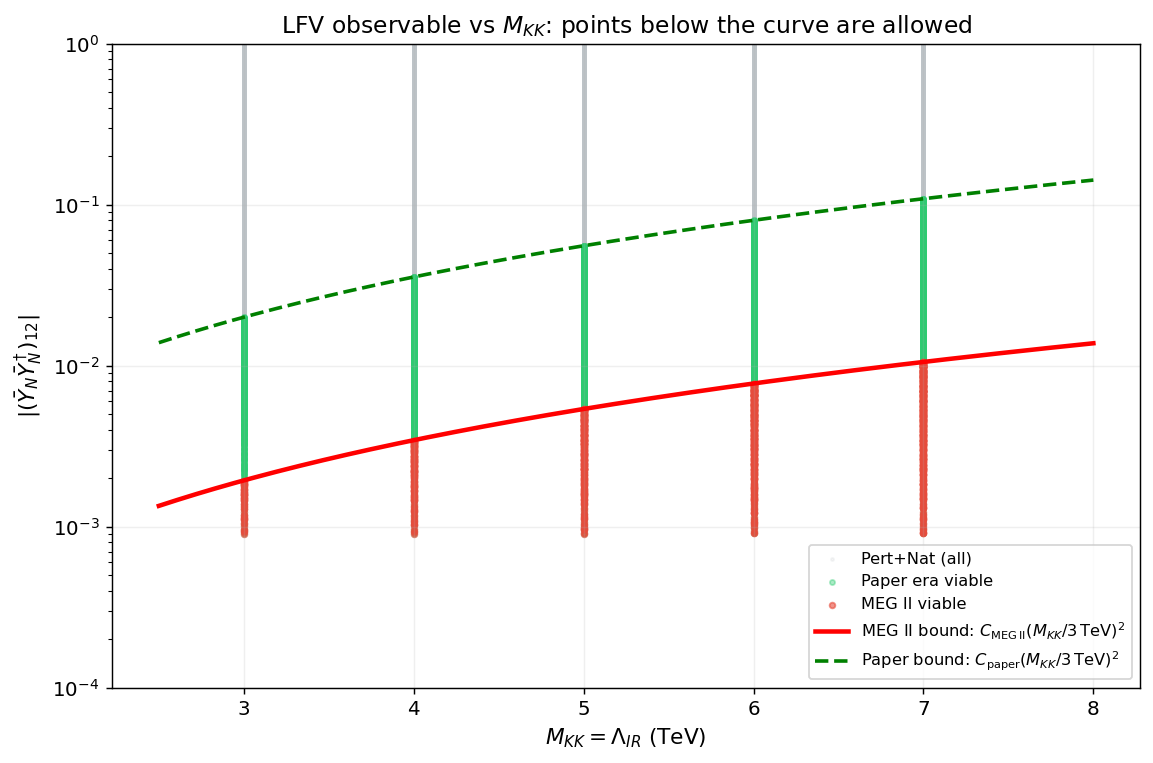

In [10]:
fig, ax = plt.subplots(figsize=(9, 6))

# Plot all perturbative+natural points
ax.scatter(pn.Lambda_IR / 1000, pn.lfv_lhs,
           c='#bdc3c7', s=3, alpha=0.15, rasterized=True, label='Pert+Nat (all)')

# Paper-era viable
ax.scatter(paper.Lambda_IR / 1000, paper.lfv_lhs,
           c='#2ecc71', s=8, alpha=0.4, rasterized=True, label='Paper era viable')

# MEG II viable
ax.scatter(viable.Lambda_IR / 1000, viable.lfv_lhs,
           c='#e74c3c', s=10, alpha=0.6, rasterized=True, label='MEG II viable')

# Bound curves
mkk_curve = np.linspace(2.5, 8, 200)
bound_megii = C_MEGII * (mkk_curve * 1000 / 3000)**2
bound_paper = C_PAPER * (mkk_curve * 1000 / 3000)**2

ax.plot(mkk_curve, bound_megii, 'r-', lw=2.5, label=r'MEG II bound: $C_{\mathrm{MEG\,II}} (M_{KK}/3\,\mathrm{TeV})^2$')
ax.plot(mkk_curve, bound_paper, 'g--', lw=2, label=r'Paper bound: $C_{\mathrm{paper}} (M_{KK}/3\,\mathrm{TeV})^2$')

ax.set_xlabel(r'$M_{KK} = \Lambda_{IR}$ (TeV)')
ax.set_ylabel(r'$|(\bar{Y}_N \bar{Y}_N^\dagger)_{12}|$')
ax.set_title(r'LFV observable vs $M_{KK}$: points below the curve are allowed')
ax.set_yscale('log')
ax.set_ylim(1e-4, 1)
ax.legend(fontsize=9, loc='lower right')
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

## 10. Yukawa "naturalness": geometric mean and max/min spread

How close to $\mathcal{O}(1)$ are the Yukawas overall?  
- Geometric mean of all 6 $|\bar{Y}|$: ideal = 1  
- Max/min ratio: measures internal hierarchy (SM has $\sim 10^6$; RS should be $\mathcal{O}(10)$)

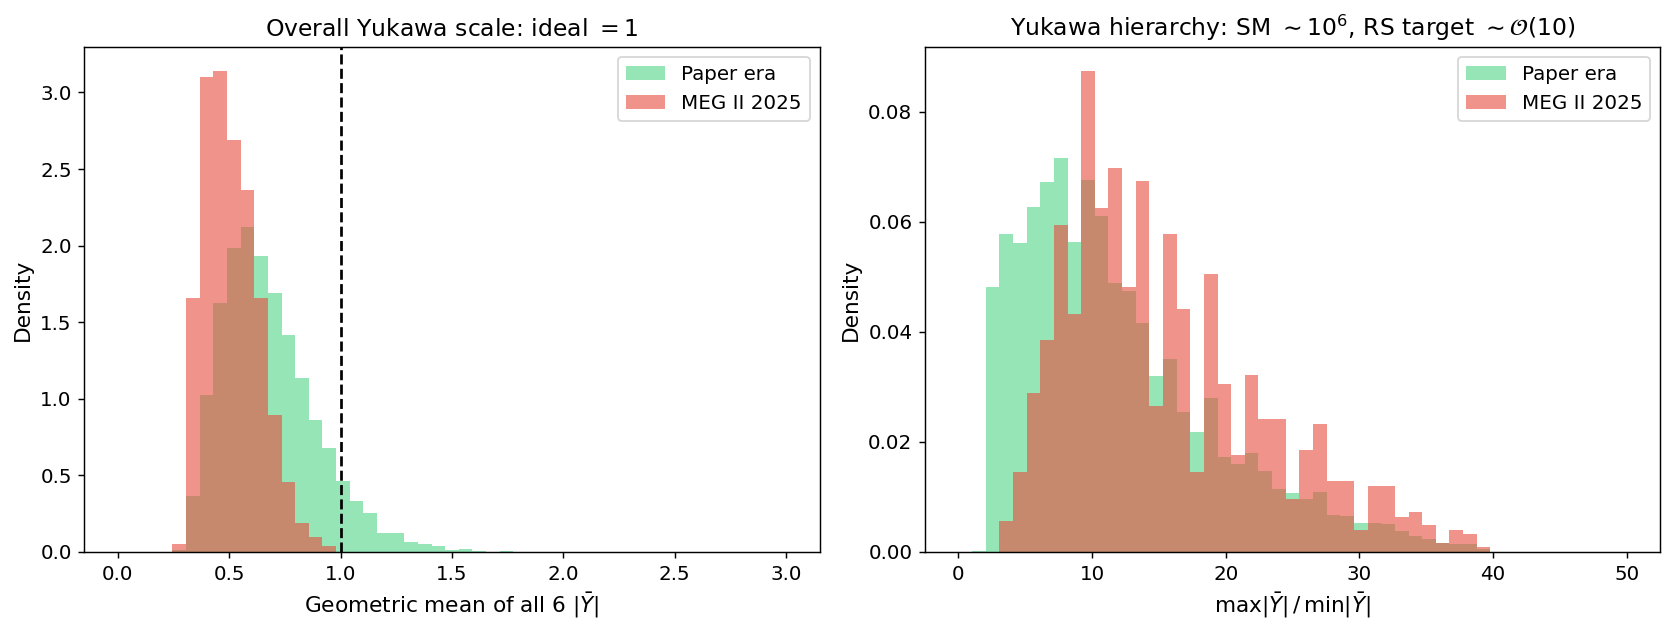

Geometric mean — Paper: 0.645 (median), MEG II: 0.493
Max/min ratio  — Paper: 10.3 (median), MEG II: 13.7


In [11]:
for data, name in [(paper, 'paper'), (viable, 'viable')]:
    vals = data[y_all_cols].values
    data = data.copy()
    data['geom_mean'] = np.exp(np.mean(np.log(np.abs(vals) + 1e-30), axis=1))
    data['max_min_ratio'] = np.max(np.abs(vals), axis=1) / (np.min(np.abs(vals), axis=1) + 1e-30)
    if name == 'paper':
        paper = data
    else:
        viable = data

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: geometric mean
ax = axes[0]
bins_gm = np.linspace(0, 3, 50)
ax.hist(paper.geom_mean, bins=bins_gm, color='#2ecc71', alpha=0.5,
        density=True, label='Paper era')
ax.hist(viable.geom_mean, bins=bins_gm, color='#e74c3c', alpha=0.6,
        density=True, label='MEG II 2025')
ax.axvline(1.0, color='black', ls='--', lw=1.5)
ax.set_xlabel(r'Geometric mean of all 6 $|\bar{Y}|$')
ax.set_ylabel('Density')
ax.set_title(r'Overall Yukawa scale: ideal $= 1$')
ax.legend()

# Right: max/min ratio
ax = axes[1]
bins_r = np.linspace(0, 50, 50)
ax.hist(paper.max_min_ratio, bins=bins_r, color='#2ecc71', alpha=0.5,
        density=True, label='Paper era')
ax.hist(viable.max_min_ratio, bins=bins_r, color='#e74c3c', alpha=0.6,
        density=True, label='MEG II 2025')
ax.set_xlabel(r'$\max|\bar{Y}| \,/\, \min|\bar{Y}|$')
ax.set_ylabel('Density')
ax.set_title(r'Yukawa hierarchy: SM $\sim 10^6$, RS target $\sim \mathcal{O}(10)$')
ax.legend()

plt.tight_layout()
plt.show()

print(f'Geometric mean — Paper: {paper.geom_mean.median():.3f} (median), MEG II: {viable.geom_mean.median():.3f}')
print(f'Max/min ratio  — Paper: {paper.max_min_ratio.median():.1f} (median), MEG II: {viable.max_min_ratio.median():.1f}')

## 11. Charged vs neutrino Yukawa scales

Scatter of $\max|\bar{Y}_E|$ vs $\max|\bar{Y}_N|$.  
The ideal RS point has both $\sim 1$. LFV pushes $\bar{Y}_N$ down while perturbativity caps $\bar{Y}_E$.

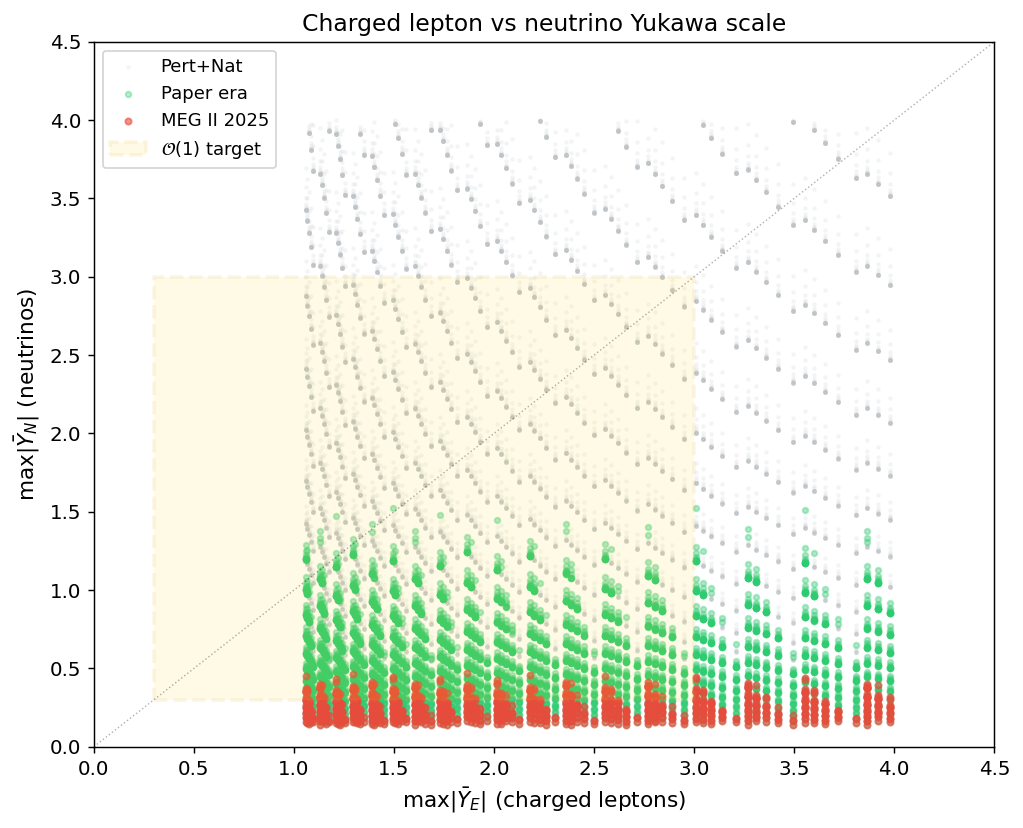

In [12]:
for data in [pn, paper, viable]:
    data['max_YE'] = data[y_E_cols].abs().max(axis=1)
    data['max_YN'] = data[y_N_cols].abs().max(axis=1)

fig, ax = plt.subplots(figsize=(8, 6.5))

ax.scatter(pn.max_YE, pn.max_YN,
           c='#bdc3c7', s=3, alpha=0.1, rasterized=True, label='Pert+Nat')
ax.scatter(paper.max_YE, paper.max_YN,
           c='#2ecc71', s=10, alpha=0.35, rasterized=True, label='Paper era')
ax.scatter(viable.max_YE, viable.max_YN,
           c='#e74c3c', s=12, alpha=0.6, rasterized=True, label='MEG II 2025')

# O(1) target box
rect = Rectangle((0.3, 0.3), 2.7, 2.7, linewidth=2, edgecolor='goldenrod',
                  facecolor='gold', alpha=0.1, linestyle='--', label=r'$\mathcal{O}(1)$ target')
ax.add_patch(rect)

ax.set_xlabel(r'$\max|\bar{Y}_E|$ (charged leptons)')
ax.set_ylabel(r'$\max|\bar{Y}_N|$ (neutrinos)')
ax.set_title(r'Charged lepton vs neutrino Yukawa scale')
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)
ax.plot([0, 4.5], [0, 4.5], 'k:', lw=0.8, alpha=0.3)
ax.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

## 12. $\bar{Y}_{\nu_3}$ (most constrained Yukawa) vs $M_{KK}$: projected

$\bar{Y}_{\nu_3}$ is the largest neutrino Yukawa and drives the LFV signal.  
At what $M_{KK}$ can it reach $\mathcal{O}(1)$?

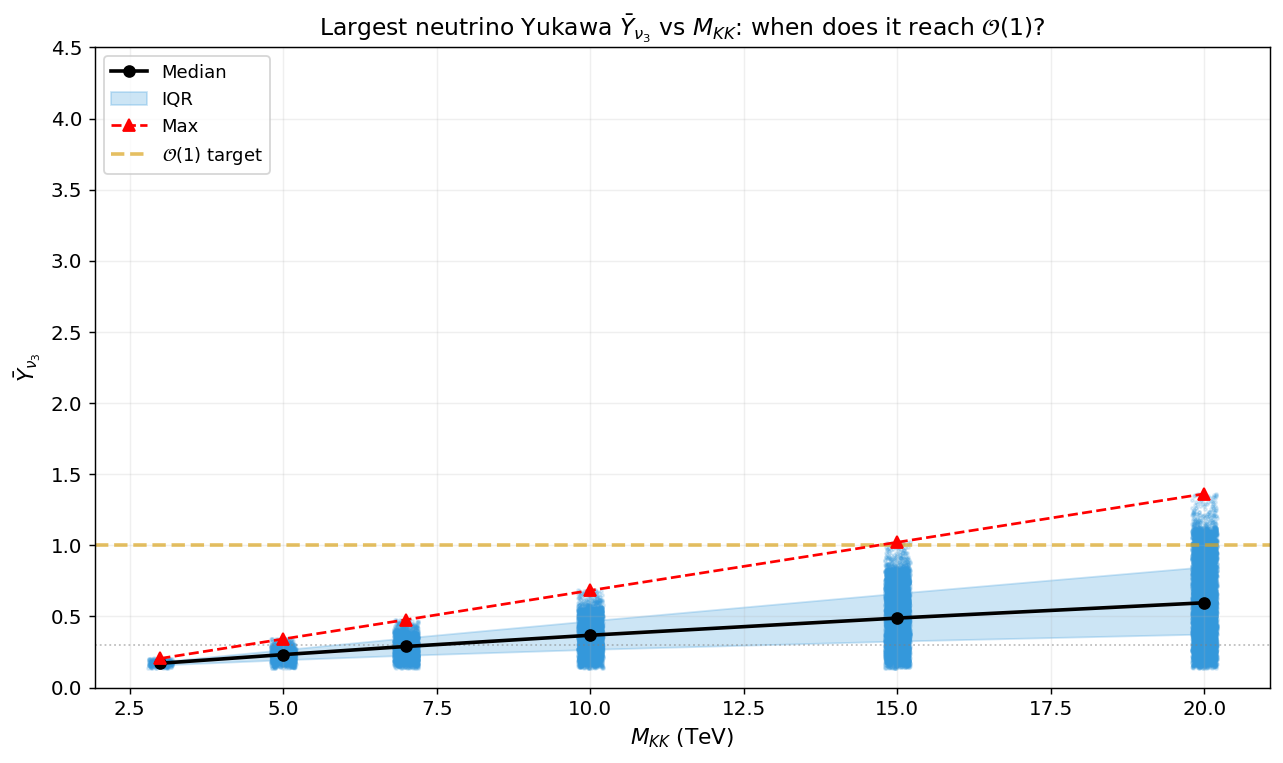

M_KK =  3 TeV:  median Y_N3 = 0.171,  max Y_N3 = 0.205
M_KK =  5 TeV:  median Y_N3 = 0.232,  max Y_N3 = 0.341
M_KK =  7 TeV:  median Y_N3 = 0.289,  max Y_N3 = 0.477
M_KK = 10 TeV:  median Y_N3 = 0.368,  max Y_N3 = 0.683
M_KK = 15 TeV:  median Y_N3 = 0.488,  max Y_N3 = 1.021
M_KK = 20 TeV:  median Y_N3 = 0.596,  max Y_N3 = 1.362


In [13]:
mkk_proj = [3, 5, 7, 10, 15, 20]

fig, ax = plt.subplots(figsize=(10, 6))

# For each projected M_KK, find viable points and plot their Y_N_3 range
medians = []
q25s, q75s = [], []
maxes = []

for mkk_tev in mkk_proj:
    mkk_gev = mkk_tev * 1000
    ratio_at_mkk = pn['lfv_lhs'] / (C_MEGII * (mkk_gev / 3000)**2)
    passes = pn[ratio_at_mkk <= 1.0]
    if len(passes) > 0:
        yn3 = passes['Y_N_bar_3']
        medians.append(yn3.median())
        q25s.append(yn3.quantile(0.25))
        q75s.append(yn3.quantile(0.75))
        maxes.append(yn3.max())
        # Jittered scatter
        jitter = np.random.default_rng(42).uniform(-0.2, 0.2, len(passes))
        ax.scatter(mkk_tev + jitter, yn3,
                  c='#3498db', s=3, alpha=0.15, rasterized=True)
    else:
        medians.append(np.nan)
        q25s.append(np.nan)
        q75s.append(np.nan)
        maxes.append(np.nan)

ax.plot(mkk_proj, medians, 'ko-', lw=2, ms=6, zorder=5, label='Median')
ax.fill_between(mkk_proj, q25s, q75s, color='#3498db', alpha=0.25, label='IQR')
ax.plot(mkk_proj, maxes, 'r^--', lw=1.5, ms=7, zorder=5, label='Max')

ax.axhline(1.0, color='goldenrod', ls='--', lw=2, alpha=0.7, label=r'$\mathcal{O}(1)$ target')
ax.axhline(0.3, color='gray', ls=':', lw=1, alpha=0.5)

ax.set_xlabel(r'$M_{KK}$ (TeV)')
ax.set_ylabel(r'$\bar{Y}_{\nu_3}$')
ax.set_title(r'Largest neutrino Yukawa $\bar{Y}_{\nu_3}$ vs $M_{KK}$'
             r': when does it reach $\mathcal{O}(1)$?')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.2)
ax.set_ylim(0, 4.5)
plt.tight_layout()
plt.show()

for mkk, med, mx in zip(mkk_proj, medians, maxes):
    print(f'M_KK = {mkk:>2d} TeV:  median Y_N3 = {med:.3f},  max Y_N3 = {mx:.3f}')

## 13. Summary: Yukawa status at a glance

In [14]:
print('=' * 70)
print('YUKAWA COUPLING SUMMARY')
print('=' * 70)
print()
print('CHARGED LEPTON YUKAWAS (MEG II viable):')
print(f'  Y_e_bar (electron):   [{viable.Y_E_bar_1.min():.3f}, {viable.Y_E_bar_1.max():.3f}]  median = {viable.Y_E_bar_1.median():.3f}')
print(f'  Y_mu_bar (muon):      [{viable.Y_E_bar_2.min():.3f}, {viable.Y_E_bar_2.max():.3f}]  median = {viable.Y_E_bar_2.median():.3f}')
print(f'  Y_tau_bar (tau):      [{viable.Y_E_bar_3.min():.3f}, {viable.Y_E_bar_3.max():.3f}]  median = {viable.Y_E_bar_3.median():.3f}')
print(f'  → All O(1) to O(few). Unaffected by LFV. Geometry works.')
print()
print('NEUTRINO YUKAWAS (MEG II viable):')
print(f'  Y_nu1_bar:            [{viable.Y_N_bar_1.min():.3f}, {viable.Y_N_bar_1.max():.3f}]  median = {viable.Y_N_bar_1.median():.3f}')
print(f'  Y_nu2_bar:            [{viable.Y_N_bar_2.min():.3f}, {viable.Y_N_bar_2.max():.3f}]  median = {viable.Y_N_bar_2.median():.3f}')
print(f'  Y_nu3_bar:            [{viable.Y_N_bar_3.min():.3f}, {viable.Y_N_bar_3.max():.3f}]  median = {viable.Y_N_bar_3.median():.3f}')
print(f'  → Squeezed to O(0.1–0.5) by MEG II. Below O(1) but not fine-tuned.')
print()
print('NEUTRINO YUKAWAS (paper era):')
print(f'  Y_nu3_bar max:        {paper.Y_N_bar_3.max():.3f}  (comfortably O(1))')
print(f'  → Paper era allowed Y_N up to ~1.5. MEG II cuts this to ~0.47.')
print()
print('KEY TENSION:')
print(f'  Geometric mean (paper):  {paper.geom_mean.median():.3f}')
print(f'  Geometric mean (MEG II): {viable.geom_mean.median():.3f}')
print(f'  → MEG II pulls geometric mean away from 1 (less "anarchic").')
print()
print('M_KK NEEDED FOR O(1) NEUTRINO YUKAWAS:')
# Find M_KK where median Y_N3 crosses 1.0
for mkk_tev in [3, 5, 7, 10, 15, 20]:
    mkk_gev = mkk_tev * 1000
    ratio_at_mkk = pn['lfv_lhs'] / (C_MEGII * (mkk_gev / 3000)**2)
    passes = pn[ratio_at_mkk <= 1.0]
    if len(passes) > 0:
        med = passes.Y_N_bar_3.median()
        mx = passes.Y_N_bar_3.max()
        marker = ' ← O(1) reached!' if mx >= 1.0 else ''
        print(f'  M_KK = {mkk_tev:>2d} TeV:  median = {med:.3f},  max = {mx:.3f}{marker}')
print('=' * 70)

YUKAWA COUPLING SUMMARY

CHARGED LEPTON YUKAWAS (MEG II viable):
  Y_e_bar (electron):   [0.470, 2.065]  median = 0.912
  Y_mu_bar (muon):      [0.795, 3.074]  median = 1.512
  Y_tau_bar (tau):      [1.060, 3.979]  median = 1.930
  → All O(1) to O(few). Unaffected by LFV. Geometry works.

NEUTRINO YUKAWAS (MEG II viable):
  Y_nu1_bar:            [0.100, 0.335]  median = 0.135
  Y_nu2_bar:            [0.102, 0.342]  median = 0.147
  Y_nu3_bar:            [0.140, 0.468]  median = 0.246
  → Squeezed to O(0.1–0.5) by MEG II. Below O(1) but not fine-tuned.

NEUTRINO YUKAWAS (paper era):
  Y_nu3_bar max:        1.525  (comfortably O(1))
  → Paper era allowed Y_N up to ~1.5. MEG II cuts this to ~0.47.

KEY TENSION:
  Geometric mean (paper):  0.645
  Geometric mean (MEG II): 0.493
  → MEG II pulls geometric mean away from 1 (less "anarchic").

M_KK NEEDED FOR O(1) NEUTRINO YUKAWAS:
  M_KK =  3 TeV:  median = 0.171,  max = 0.205
  M_KK =  5 TeV:  median = 0.232,  max = 0.341
  M_KK =  7 TeV:  m